In [57]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import datetime as dt
from matplotlib import pyplot as plt

In [58]:
train = pd.read_csv("train.csv")
train

,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [59]:
time_format = "%d.%m.%Y %H:%M:%S"
train["datetime"] = [dt.datetime.strptime(s, time_format) for s in train["datetime"]]

In [60]:
train["season"] = [date.month % 4 for date in train["datetime"]]
train["is_weekend"] = [date.weekday() >= 5 for date in train["datetime"]]
train["hour"] = [date.hour for date in train["datetime"]]

In [61]:
median_total = np.median(train["total"][train["total"] != "?"].astype(np.int64))
train["total"].replace("?", median_total, inplace=True)

In [62]:
train

,datetime,total,season,is_weekend,hour
0,2005-01-01 00:00:00,195441.5,1,True,0
1,2005-01-01 01:00:00,154140,1,True,1
2,2005-01-01 02:00:00,157818,1,True,2
3,2005-01-01 03:00:00,149311,1,True,3
4,2005-01-01 04:00:00,138282,1,True,4
...,...,...,...,...,...
35059,2008-12-31 19:00:00,249376,0,False,19
35060,2008-12-31 20:00:00,246511,0,False,20
35061,2008-12-31 21:00:00,226469,0,False,21
35062,2008-12-31 22:00:00,199907,0,False,22


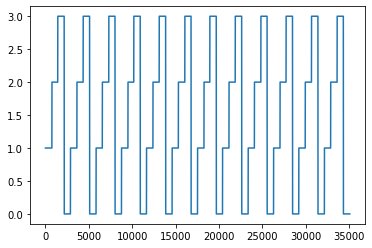

In [63]:
plt.plot(train["season"])

In [5]:
series = train.total.values

In [6]:
ar = AutoReg(series, lags=168).fit()

In [7]:
answer = ar.predict(start=35064, end=35064+4344-1, dynamic=False)

In [8]:
with open("answer.txt", "w") as f:
    for v in answer:
        f.write(str(v))
        f.write('\n')